# Overview
- モデルをlightGBMにした
- 009からさらにfeatureを削ってみる

# Const

In [1]:
path_X_tr = './../../Dataset-CareerCon-2019-Help-Navigate-Robots/Tutorial/data/X_train.csv'
path_y_tr = './../../Dataset-CareerCon-2019-Help-Navigate-Robots/Tutorial/data/y_train.csv'
path_X_te = './../../Dataset-CareerCon-2019-Help-Navigate-Robots/Tutorial/data/X_test.csv'

# Import everything I need :)

In [17]:
import sys
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
from fastprogress import progress_bar
sys.path.insert(0, './../../Dataset-CareerCon-2019-Help-Navigate-Robots/Tutorial/secret-data')
from tell_me_score import tell_me_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import librosa
import copy
import lightgbm as lgb

# myfnuc

In [18]:
class permutation_importance():
    def __init__(self, model, metric):
        self.is_computed = False
        self.n_feat = 0
        self.base_score = 0
        self.model = model
        self.metric = metric
        self.df_result = []
    
    def compute(self, X_valid, y_valid):
        self.n_feat = len(X_valid.columns)
        if self.metric == 'auc':
            y_valid_score = self.model.predict_proba(X_valid)[:, 1]
            fpr, tpr, thresholds = roc_curve(y_valid, y_valid_score)
            self.base_score = auc(fpr, tpr)
        else:
            self.base_score = self.metric(y_valid, self.model.predict(X_valid))
        self.df_result = pd.DataFrame({'feat': X_valid.columns, 
                                       'score': np.zeros(self.n_feat),
                                       'score_diff': np.zeros(self.n_feat)})
        
        # predict
        for i, col in enumerate(X_valid.columns):
            df_perm = X_valid.copy()
            np.random.seed(1)
            df_perm[col] = np.random.permutation(df_perm[col])
            y_valid_pred = self.model.predict(df_perm)
            if self.metric == 'auc':
                y_valid_score = self.model.predict_proba(df_perm)[:, 1]
                fpr, tpr, thresholds = roc_curve(y_valid, y_valid_score)
                score = auc(fpr, tpr)
            else:
                score = self.metric(y_valid, y_valid_pred)
            self.df_result['score'][self.df_result['feat']==col] = score
            self.df_result['score_diff'][self.df_result['feat']==col] = self.base_score - score
        self.is_computed = True
    
    def get_negative_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        idx = self.df_result['score_diff'] < 0
        return self.df_result.loc[idx, 'feat'].values.tolist()
        
    def get_positive_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        idx = self.df_result['score_diff'] > 0
        return self.df_result.loc[idx, 'feat'].values.tolist()
    
    def show_permutation_importance(self, score_type='loss'):
        '''score_type = 'loss' or 'accuracy'  '''
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        if score_type=='loss':
            ascending = True
        elif score_type=='accuracy':
            ascending = False
        else:
            ascending = ''
        
        plt.figure(figsize=(15, int(0.25*self.n_feat)))
        sns.barplot(x="score_diff", y="feat", data=self.df_result.sort_values(by="score_diff", ascending=ascending))
        plt.title('base_score - permutation_score')

In [19]:
def plot_confusion_matrix(truth, pred, classes, normalize=False, title=''):
    cm = confusion_matrix(truth, pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', size=15)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()

# Preparation

set

In [20]:
sns.set()
warnings.filterwarnings('ignore')

<br>

load data

In [21]:
df_X = pd.read_csv(path_X_tr)
df_y = pd.read_csv(path_y_tr)

df_X_te = pd.read_csv(path_X_te)

<br>

label encoding

In [22]:
le = LabelEncoder()
le.fit(df_y['surface'].values)
y = le.transform(df_y['surface'].values)

In [23]:
y.shape

(2667,)

# EDA

In [24]:
df_X.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,1_0,1,0,-0.95896,0.24074,0.030758,-0.14661,0.283420,0.002192,-0.050810,2.18480,2.25260,-8.9503
1,1_1,1,1,-0.95890,0.24079,0.030786,-0.14693,0.108930,-0.009485,0.009155,0.49905,2.97620,-5.4953
2,1_2,1,2,-0.95889,0.24076,0.030807,-0.14702,-0.073197,0.003959,-0.023384,0.74827,1.68030,-7.3061
3,1_3,1,3,-0.95888,0.24076,0.030742,-0.14712,-0.064979,0.068265,0.018673,1.84080,0.22349,-11.4910
4,1_4,1,4,-0.95888,0.24079,0.030707,-0.14702,0.077929,0.005519,0.022119,-0.49667,-0.92942,-12.2980


<br>

特徴量作成
- 1series_id 1特徴量にしなければならない
- 今回は、`series_id` ごとに平均値を出してみた

In [25]:
feat_names = ['orientation_X', 'orientation_Y', 'orientation_Z', 
              'orientation_W', 'angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z', 
              'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z']

In [26]:
# groupbyをつかって `series_id` 毎に平均値を作成
X = df_X.groupby('series_id')[feat_names].mean()
X_te = df_X_te.groupby('series_id')[feat_names].mean()

In [27]:
X.head()

,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
series_id,,,,,,,,,,
1,-0.958606,0.241867,0.031650,-0.146876,0.004605,-0.007757,0.006206,0.121867,2.768193,-9.388899
3,-0.939169,0.310140,0.038955,-0.142319,0.000624,-0.002804,0.007887,0.201791,2.657922,-9.451164
4,-0.891301,0.428144,0.060056,-0.136460,0.006969,0.046109,-0.142385,-0.086171,2.981498,-9.349988
5,0.464712,-0.872496,-0.127264,0.081212,-0.007366,-0.000134,-0.006881,0.109911,2.668945,-9.285242
6,-0.402356,-0.903141,-0.140541,-0.051849,0.010419,0.017725,-0.050957,0.175171,2.640550,-9.465020


In [28]:
# 標準偏差も入れてみる
X_var = df_X.groupby('series_id')[feat_names].std()
X_var_te = df_X_te.groupby('series_id')[feat_names].std()
feat_names_var = X_var.columns
feat_names_var = [ name + "_var" for name in feat_names_var ]
X_var.columns = feat_names_var
X_var_te.columns = feat_names_var


In [29]:
X_var.head()

,orientation_X_var,orientation_Y_var,orientation_Z_var,orientation_W_var,angular_velocity_X_var,angular_velocity_Y_var,angular_velocity_Z_var,linear_acceleration_X_var,linear_acceleration_Y_var,linear_acceleration_Z_var
series_id,,,,,,,,,,
1,0.000151,0.000499,0.000508,0.000521,0.092309,0.046523,0.067533,1.105945,1.864457,2.123065
3,0.000227,0.000453,0.000449,0.001371,0.179544,0.046700,0.032265,1.472019,4.201410,3.478530
4,0.002955,0.006165,0.000985,0.000541,0.044773,0.016114,0.038489,0.437707,1.137776,0.812585
5,0.000315,0.000225,0.000658,0.000376,0.098252,0.055027,0.052613,1.544754,2.280124,2.280960
6,0.002120,0.001013,0.000318,0.000557,0.025530,0.011644,0.015867,0.449003,0.671358,0.496206


In [30]:
X_var_te.head()

,orientation_X_var,orientation_Y_var,orientation_Z_var,orientation_W_var,angular_velocity_X_var,angular_velocity_Y_var,angular_velocity_Z_var,linear_acceleration_X_var,linear_acceleration_Y_var,linear_acceleration_Z_var
series_id,,,,,,,,,,
0,0.000363,0.000471,0.000432,0.000389,0.052800,0.031544,0.017127,0.911175,1.387790,1.095040
2,0.001377,0.000785,0.000541,0.000278,0.060168,0.035530,0.021866,0.756138,1.769792,1.140267
9,0.021568,0.028636,0.004359,0.003011,0.083914,0.064916,0.035946,1.702722,1.927859,2.137469
10,0.000878,0.001494,0.000368,0.000555,0.048430,0.039834,0.028673,1.184800,1.217480,1.123871
13,0.003819,0.001530,0.000668,0.001280,0.053344,0.046725,0.032170,1.408443,1.004574,1.330694


In [31]:
# featureをどんどん追加してみる
feat_names = ['angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z', 
              'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z']
series_id_list = df_X['series_id'].unique()

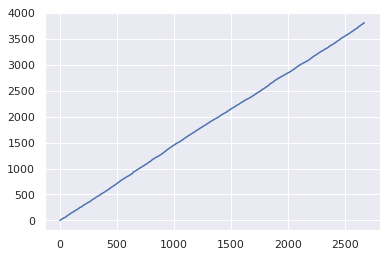

In [60]:
plt.plot(series_id_list)

In [32]:
df_new = pd.DataFrame( columns=['series_id',
#                                 'angular_velocity_X_zcr'   ,'angular_velocity_Y_zcr'   ,'angular_velocity_Z_zcr',
#                                 'linear_acceleration_X_zcr','linear_acceleration_Y_zcr','linear_acceleration_Z_zcr',
#                                 'angular_velocity_X_centroid'   ,'angular_velocity_Y_centroid'   ,'angular_velocity_Z_centroid',
#                                 'linear_acceleration_X_centroid','linear_acceleration_Y_centroid','linear_acceleration_Z_centroid',
#                                   'angular_velocity_X_bandwidth'   ,'angular_velocity_Y_bandwidth'   ,'angular_velocity_Z_bandwidth',
#                                  'linear_acceleration_X_bandwidth','linear_acceleration_Y_bandwidth','linear_acceleration_Z_bandwidth',
#                                  'angular_velocity_X_contrast'   ,'angular_velocity_Y_contrast'   ,'angular_velocity_Z_contrast',
#                                  'linear_acceleration_X_contrast','linear_acceleration_Y_contrast','linear_acceleration_Z_contrast',
                                  'angular_velocity_X_flatness'   ,'angular_velocity_Y_flatness'   ,'angular_velocity_Z_flatness',
                                 'linear_acceleration_X_flatness','linear_acceleration_Y_flatness','linear_acceleration_Z_flatness',
#                                  'angular_velocity_X_rolloff'   ,'angular_velocity_Y_rolloff'   ,'angular_velocity_Z_rolloff',
#                                   'linear_acceleration_X_rolloff','linear_acceleration_Y_rolloff','linear_acceleration_Z_rolloff',
#                                 'angular_velocity_X_lpc1'   ,'angular_velocity_Y_lpc1'   ,'angular_velocity_Z_lpc1',
#                                  'linear_acceleration_X_lpc1','linear_acceleration_Y_lpc1','linear_acceleration_Z_lpc1',
#                                    'angular_velocity_X_lpc2'   ,'angular_velocity_Y_lpc2'   ,'angular_velocity_Z_lpc2',
#                                  'linear_acceleration_X_lpc2','linear_acceleration_Y_lpc2','linear_acceleration_Z_lpc2', 
#                                     'angular_velocity_X_lpc3'   ,'angular_velocity_Y_lpc3'   ,'angular_velocity_Z_lpc3',
#                                  'linear_acceleration_X_lpc3','linear_acceleration_Y_lpc3','linear_acceleration_Z_lpc3',
#                                 'angular_velocity_X_lpc4'   ,'angular_velocity_Y_lpc4'   ,'angular_velocity_Z_lpc4',
#                                  'linear_acceleration_X_lpc4','linear_acceleration_Y_lpc4','linear_acceleration_Z_lpc4',
#                                    'angular_velocity_X_lpc5'   ,'angular_velocity_Y_lpc5'   ,'angular_velocity_Z_lpc5',
#                                  'linear_acceleration_X_lpc5','linear_acceleration_Y_lpc5','linear_acceleration_Z_lpc5',
#                                     'angular_velocity_X_lpc6'   ,'angular_velocity_Y_lpc6'   ,'angular_velocity_Z_lpc6',
#                                  'linear_acceleration_X_lpc6','linear_acceleration_Y_lpc6','linear_acceleration_Z_lpc6',
#                                     'angular_velocity_X_lpc7'   ,'angular_velocity_Y_lpc7'   ,'angular_velocity_Z_lpc7',
#                                  'linear_acceleration_X_lpc7','linear_acceleration_Y_lpc7','linear_acceleration_Z_lpc7',
#                                     'angular_velocity_X_lpc8'   ,'angular_velocity_Y_lpc8'   ,'angular_velocity_Z_lpc8',
#                                  'linear_acceleration_X_lpc8','linear_acceleration_Y_lpc8','linear_acceleration_Z_lpc8',
#                                     'angular_velocity_X_lpc9'   ,'angular_velocity_Y_lpc9'   ,'angular_velocity_Z_lpc9',
#                                  'linear_acceleration_X_lpc9','linear_acceleration_Y_lpc9','linear_acceleration_Z_lpc9',
#                                     'angular_velocity_X_lpc10'   ,'angular_velocity_Y_lpc10'   ,'angular_velocity_Z_lpc10',
#                                  'linear_acceleration_X_lpc10','linear_acceleration_Y_lpc10','linear_acceleration_Z_lpc10',
                               ] )


sr = 0.1
for series_id in series_id_list:
    
    new_feat_val_list = [int(series_id)]

    for feat_name in feat_names:
    # zcr
        
#         yy = df_X[df_X['series_id']==series_id][feat_name].values
#         #val = librosa.feature.zero_crossing_rate(yy,frame_length=128)
#         val = librosa.feature.zero_crossing_rate(yy)
#         new_feat_val_list.append(val[0][0])
        
    
#     # centroid
#         yy = df_X[df_X['series_id']==series_id][feat_name].values
#         val = librosa.feature.spectral_centroid(y=yy, sr=sr)
#         new_feat_val_list.append(val[0][0])
        
        
    # bandwidth
#         yy = df_X[df_X['series_id']==series_id][feat_name].values
#         val = librosa.feature.spectral_bandwidth(y=yy, sr=sr)
#         new_feat_val_list.append(val[0][0])
        
    
    # contrast
#         yy = df_X[df_X['series_id']==series_id][feat_name].values
#         S = np.abs(librosa.stft(yy))
#         val = librosa.feature.spectral_contrast(S=S, sr=sr)
#         new_feat_val_list.append(val[0][0])
    
    # flatness
        yy = df_X[df_X['series_id']==series_id][feat_name].values
        val = librosa.feature.spectral_flatness(y=yy)
        new_feat_val_list.append(val[0][0])

        
#     # rolloff
#         yy = df_X[df_X['series_id']==series_id][feat_name].values
#         val = librosa.feature.spectral_rolloff(y=yy, sr=sr)
#         new_feat_val_list.append(val[0][0])

        
#     # lpc
#         yy = df_X[df_X['series_id']==series_id][feat_name].values
#         val = librosa.lpc(yy, 10)
#         for i in range(1,11):
#             new_feat_val_list.append(val[i])
            
    tmp_se = pd.Series( new_feat_val_list, index=df_new.columns )
    
    df_new = df_new.append( tmp_se, ignore_index=True )    


In [33]:
df_new.head()

,series_id,angular_velocity_X_flatness,angular_velocity_Y_flatness,angular_velocity_Z_flatness,linear_acceleration_X_flatness,linear_acceleration_Y_flatness,linear_acceleration_Z_flatness
0,1.0,0.000445,0.000962,0.000151,0.002820,0.000198,0.000029
1,3.0,0.000346,0.001934,0.000488,0.001681,0.000293,0.000108
2,4.0,0.000195,0.000051,0.000002,0.000497,0.000013,0.000002
3,5.0,0.000558,0.000914,0.000238,0.001393,0.000257,0.000045
4,6.0,0.000376,0.000296,0.000012,0.000850,0.000016,0.000002


In [34]:
series_id_list_te = df_X_te['series_id'].unique()

In [35]:
df_new_te = pd.DataFrame( columns=['series_id',
#                                 'angular_velocity_X_zcr'   ,'angular_velocity_Y_zcr'   ,'angular_velocity_Z_zcr',
#                                 'linear_acceleration_X_zcr','linear_acceleration_Y_zcr','linear_acceleration_Z_zcr',
#                                 'angular_velocity_X_centroid'   ,'angular_velocity_Y_centroid'   ,'angular_velocity_Z_centroid',
#                                 'linear_acceleration_X_centroid','linear_acceleration_Y_centroid','linear_acceleration_Z_centroid',
#                                   'angular_velocity_X_bandwidth'   ,'angular_velocity_Y_bandwidth'   ,'angular_velocity_Z_bandwidth',
#                                  'linear_acceleration_X_bandwidth','linear_acceleration_Y_bandwidth','linear_acceleration_Z_bandwidth',
#                                  'angular_velocity_X_contrast'   ,'angular_velocity_Y_contrast'   ,'angular_velocity_Z_contrast',
#                                  'linear_acceleration_X_contrast','linear_acceleration_Y_contrast','linear_acceleration_Z_contrast',
                                  'angular_velocity_X_flatness'   ,'angular_velocity_Y_flatness'   ,'angular_velocity_Z_flatness',
                                 'linear_acceleration_X_flatness','linear_acceleration_Y_flatness','linear_acceleration_Z_flatness',
#                                  'angular_velocity_X_rolloff'   ,'angular_velocity_Y_rolloff'   ,'angular_velocity_Z_rolloff',
#                                   'linear_acceleration_X_rolloff','linear_acceleration_Y_rolloff','linear_acceleration_Z_rolloff',
#                                 'angular_velocity_X_lpc1'   ,'angular_velocity_Y_lpc1'   ,'angular_velocity_Z_lpc1',
#                                  'linear_acceleration_X_lpc1','linear_acceleration_Y_lpc1','linear_acceleration_Z_lpc1',
#                                    'angular_velocity_X_lpc2'   ,'angular_velocity_Y_lpc2'   ,'angular_velocity_Z_lpc2',
#                                  'linear_acceleration_X_lpc2','linear_acceleration_Y_lpc2','linear_acceleration_Z_lpc2', 
#                                     'angular_velocity_X_lpc3'   ,'angular_velocity_Y_lpc3'   ,'angular_velocity_Z_lpc3',
#                                  'linear_acceleration_X_lpc3','linear_acceleration_Y_lpc3','linear_acceleration_Z_lpc3',
#                                 'angular_velocity_X_lpc4'   ,'angular_velocity_Y_lpc4'   ,'angular_velocity_Z_lpc4',
#                                  'linear_acceleration_X_lpc4','linear_acceleration_Y_lpc4','linear_acceleration_Z_lpc4',
#                                    'angular_velocity_X_lpc5'   ,'angular_velocity_Y_lpc5'   ,'angular_velocity_Z_lpc5',
#                                  'linear_acceleration_X_lpc5','linear_acceleration_Y_lpc5','linear_acceleration_Z_lpc5',
#                                     'angular_velocity_X_lpc6'   ,'angular_velocity_Y_lpc6'   ,'angular_velocity_Z_lpc6',
#                                  'linear_acceleration_X_lpc6','linear_acceleration_Y_lpc6','linear_acceleration_Z_lpc6',
#                                     'angular_velocity_X_lpc7'   ,'angular_velocity_Y_lpc7'   ,'angular_velocity_Z_lpc7',
#                                  'linear_acceleration_X_lpc7','linear_acceleration_Y_lpc7','linear_acceleration_Z_lpc7',
#                                     'angular_velocity_X_lpc8'   ,'angular_velocity_Y_lpc8'   ,'angular_velocity_Z_lpc8',
#                                  'linear_acceleration_X_lpc8','linear_acceleration_Y_lpc8','linear_acceleration_Z_lpc8',
#                                     'angular_velocity_X_lpc9'   ,'angular_velocity_Y_lpc9'   ,'angular_velocity_Z_lpc9',
#                                  'linear_acceleration_X_lpc9','linear_acceleration_Y_lpc9','linear_acceleration_Z_lpc9',
#                                     'angular_velocity_X_lpc10'   ,'angular_velocity_Y_lpc10'   ,'angular_velocity_Z_lpc10',
#                                  'linear_acceleration_X_lpc10','linear_acceleration_Y_lpc10','linear_acceleration_Z_lpc10',
                               ] )


sr = 0.1
for series_id in series_id_list_te:
    
    new_feat_val_list_te = [int(series_id)]

    for feat_name in feat_names:
    # zcr
        
#         yy = df_X_te[df_X_te['series_id']==series_id][feat_name].values
#         val = librosa.feature.zero_crossing_rate(yy)
#         new_feat_val_list_te.append(val[0][0])
        
    
    # centroid
#         yy = df_X_te[df_X_te['series_id']==series_id][feat_name].values
#         val = librosa.feature.spectral_centroid(y=yy, sr=sr)
#         new_feat_val_list_te.append(val[0][0])
        
        
    # bandwidth
#         yy = df_X_te[df_X_te['series_id']==series_id][feat_name].values
#         val = librosa.feature.spectral_bandwidth(y=yy, sr=sr)
#         new_feat_val_list_te.append(val[0][0])
        
    
    # contrast
  #  for feat_name in feat_names:
  #      yy = df_X[df_X['series_id']==series_id][feat_name].values
  #      S = np.abs(librosa.stft(y))
        #val = librosa.feature.spectral_contrast(S=S, sr=sr)
        #new_feat_val_list.append(val[0][0])
    
    # flatness
        yy = df_X_te[df_X_te['series_id']==series_id][feat_name].values
        val = librosa.feature.spectral_flatness(y=yy)
        new_feat_val_list_te.append(val[0][0])

        
#     # rolloff
#         yy = df_X_te[df_X_te['series_id']==series_id][feat_name].values
#         val = librosa.feature.spectral_rolloff(y=yy, sr=sr)
#         new_feat_val_list_te.append(val[0][0])

        
    # lpc
#         yy = df_X_te[df_X_te['series_id']==series_id][feat_name].values
#         val = librosa.lpc(yy, 10)
#         for i in range(1,11):
#             new_feat_val_list_te.append(val[i])
            
    tmp_se_te = pd.Series( new_feat_val_list_te, index=df_new_te.columns )
    
    df_new_te = df_new_te.append( tmp_se_te, ignore_index=True )    


In [36]:
df_new['series_id'] = df_new['series_id'].astype(np.int64)
df_new.head()

,series_id,angular_velocity_X_flatness,angular_velocity_Y_flatness,angular_velocity_Z_flatness,linear_acceleration_X_flatness,linear_acceleration_Y_flatness,linear_acceleration_Z_flatness
0,1,0.000445,0.000962,0.000151,0.002820,0.000198,0.000029
1,3,0.000346,0.001934,0.000488,0.001681,0.000293,0.000108
2,4,0.000195,0.000051,0.000002,0.000497,0.000013,0.000002
3,5,0.000558,0.000914,0.000238,0.001393,0.000257,0.000045
4,6,0.000376,0.000296,0.000012,0.000850,0.000016,0.000002


In [37]:
df_new_te['series_id'] = df_new_te['series_id'].astype(np.int64)
df_new_te.head()

,series_id,angular_velocity_X_flatness,angular_velocity_Y_flatness,angular_velocity_Z_flatness,linear_acceleration_X_flatness,linear_acceleration_Y_flatness,linear_acceleration_Z_flatness
0,0,0.000403,0.000674,3.698212e-04,0.000723,0.000045,0.000011
1,2,0.000789,0.000630,1.123672e-04,0.001683,0.000089,0.000017
2,9,0.000473,0.000030,4.294518e-07,0.000735,0.000110,0.000031
3,10,0.000601,0.000767,8.224960e-05,0.000857,0.000083,0.000015
4,13,0.000617,0.000285,2.627131e-05,0.000551,0.000083,0.000016


In [38]:
X.head()

,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
series_id,,,,,,,,,,
1,-0.958606,0.241867,0.031650,-0.146876,0.004605,-0.007757,0.006206,0.121867,2.768193,-9.388899
3,-0.939169,0.310140,0.038955,-0.142319,0.000624,-0.002804,0.007887,0.201791,2.657922,-9.451164
4,-0.891301,0.428144,0.060056,-0.136460,0.006969,0.046109,-0.142385,-0.086171,2.981498,-9.349988
5,0.464712,-0.872496,-0.127264,0.081212,-0.007366,-0.000134,-0.006881,0.109911,2.668945,-9.285242
6,-0.402356,-0.903141,-0.140541,-0.051849,0.010419,0.017725,-0.050957,0.175171,2.640550,-9.465020


In [39]:
X_plus = pd.merge(X,X_var,on='series_id')
X_plus = pd.merge(X_plus,df_new,on='series_id')

X_plus_te = pd.merge(X_te,X_var_te,on='series_id')
X_plus_te = pd.merge(X_plus_te,df_new_te,on='series_id')

#X_te_plus_v = pd.merge(X_te,X_plus_te,on='series_id')

In [40]:
X_plus.head()

,series_id,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,...,angular_velocity_Z_var,linear_acceleration_X_var,linear_acceleration_Y_var,linear_acceleration_Z_var,angular_velocity_X_flatness,angular_velocity_Y_flatness,angular_velocity_Z_flatness,linear_acceleration_X_flatness,linear_acceleration_Y_flatness,linear_acceleration_Z_flatness
0,1,-0.958606,0.241867,0.031650,-0.146876,0.004605,-0.007757,0.006206,0.121867,2.768193,...,0.067533,1.105945,1.864457,2.123065,0.000445,0.000962,0.000151,0.002820,0.000198,0.000029
1,3,-0.939169,0.310140,0.038955,-0.142319,0.000624,-0.002804,0.007887,0.201791,2.657922,...,0.032265,1.472019,4.201410,3.478530,0.000346,0.001934,0.000488,0.001681,0.000293,0.000108
2,4,-0.891301,0.428144,0.060056,-0.136460,0.006969,0.046109,-0.142385,-0.086171,2.981498,...,0.038489,0.437707,1.137776,0.812585,0.000195,0.000051,0.000002,0.000497,0.000013,0.000002
3,5,0.464712,-0.872496,-0.127264,0.081212,-0.007366,-0.000134,-0.006881,0.109911,2.668945,...,0.052613,1.544754,2.280124,2.280960,0.000558,0.000914,0.000238,0.001393,0.000257,0.000045
4,6,-0.402356,-0.903141,-0.140541,-0.051849,0.010419,0.017725,-0.050957,0.175171,2.640550,...,0.015867,0.449003,0.671358,0.496206,0.000376,0.000296,0.000012,0.000850,0.000016,0.000002


In [41]:
X_plus_te.head()

,series_id,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,...,angular_velocity_Z_var,linear_acceleration_X_var,linear_acceleration_Y_var,linear_acceleration_Z_var,angular_velocity_X_flatness,angular_velocity_Y_flatness,angular_velocity_Z_flatness,linear_acceleration_X_flatness,linear_acceleration_Y_flatness,linear_acceleration_Z_flatness
0,0,-0.758666,-0.634008,-0.105474,-0.106470,-0.002481,-0.003306,0.007532,0.263418,2.984195,...,0.017127,0.911175,1.387790,1.095040,0.000403,0.000674,3.698212e-04,0.000723,0.000045,0.000011
1,2,-0.512057,-0.846171,-0.129371,-0.071082,0.002646,-0.009232,0.027989,0.149711,2.886745,...,0.021866,0.756138,1.769792,1.140267,0.000789,0.000630,1.123672e-04,0.001683,0.000089,0.000017
2,9,0.789137,-0.594258,-0.083210,0.126072,-0.007559,-0.225973,0.739494,0.554170,3.381636,...,0.035946,1.702722,1.927859,2.137469,0.000473,0.000030,4.294518e-07,0.000735,0.000110,0.000031
3,10,0.848894,-0.507936,-0.071876,0.127325,-0.000087,-0.008526,0.037698,0.147020,2.856557,...,0.028673,1.184800,1.217480,1.123871,0.000601,0.000767,8.224960e-05,0.000857,0.000083,0.000015
4,13,0.374334,0.914796,0.143148,0.050117,-0.000462,0.039265,-0.086745,0.001663,2.733913,...,0.032170,1.408443,1.004574,1.330694,0.000617,0.000285,2.627131e-05,0.000551,0.000083,0.000016


In [42]:
# 標準化
sc = StandardScaler()
X_plus_val = X_plus.drop(["series_id"],axis=1)
val_columns = X_plus_val.columns
X_plus_val_std = pd.DataFrame(sc.fit_transform(X_plus_val),columns=val_columns)
X_plus_std = copy.deepcopy(X_plus)
X_plus_std[val_columns] = X_plus_val_std
#X_plus_std = X_plus_std.drop('series_id',axis=1)
X_plus_std.head()

,series_id,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,...,angular_velocity_Z_var,linear_acceleration_X_var,linear_acceleration_Y_var,linear_acceleration_Z_var,angular_velocity_X_flatness,angular_velocity_Y_flatness,angular_velocity_Z_flatness,linear_acceleration_X_flatness,linear_acceleration_Y_flatness,linear_acceleration_Z_flatness
0,1,-1.377856,0.229835,0.175701,-1.377866,0.408056,-0.227192,0.105490,-0.039056,-0.458216,...,0.328028,-0.296099,0.113355,-0.013055,-0.178737,0.669784,0.036310,3.579470,0.054554,-0.190960
1,3,-1.349390,0.325921,0.244305,-1.333989,0.047116,-0.153334,0.113292,0.380541,-0.897452,...,-0.467311,0.009551,1.885671,0.698015,-0.409183,2.639123,0.955239,1.385106,0.450525,0.655295
2,4,-1.279285,0.491998,0.442483,-1.277578,0.622410,0.576089,-0.584488,-1.131261,0.391431,...,-0.326954,-0.854038,-0.437750,-0.700527,-0.761631,-1.178366,-0.370790,-0.894367,-0.718250,-0.480708
3,5,0.706639,-1.338502,-1.316772,0.818401,-0.677352,-0.113523,0.044722,-0.101825,-0.853545,...,-0.008428,0.070280,0.428592,0.069776,0.082800,0.571046,0.271267,0.831053,0.299769,-0.017435
4,6,-0.563210,-1.381632,-1.441467,-0.462849,0.935193,0.152815,-0.159945,0.240790,-0.966650,...,-0.837108,-0.844607,-0.791475,-0.866499,-0.339253,-0.681540,-0.342805,-0.214917,-0.708859,-0.490201


In [43]:
# 標準化
X_plus_val_te = X_plus_te.drop(["series_id"],axis=1)
val_columns = X_plus_val_te.columns
X_plus_val_std_te = pd.DataFrame(sc.fit_transform(X_plus_val_te),columns=val_columns)
X_plus_std_te = copy.deepcopy(X_plus_te)
X_plus_std_te[val_columns] = X_plus_val_std_te
#X_plus_std_te = X_plus_std_te.drop('series_id',axis=1)
X_plus_std_te.head()

,series_id,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,...,angular_velocity_Z_var,linear_acceleration_X_var,linear_acceleration_Y_var,linear_acceleration_Z_var,angular_velocity_X_flatness,angular_velocity_Y_flatness,angular_velocity_Z_flatness,linear_acceleration_X_flatness,linear_acceleration_Y_flatness,linear_acceleration_Z_flatness
0,0,-1.069010,-0.997579,-1.115056,-0.974408,-0.324769,-0.193700,0.145457,0.727153,0.372291,...,-0.835021,-0.454763,-0.257976,-0.551687,-0.252981,0.071009,0.743903,-0.486409,-0.605491,-0.372116
1,2,-0.712762,-1.299544,-1.343185,-0.638368,0.263737,-0.277791,0.235767,0.111028,-0.030061,...,-0.721329,-0.591844,0.065463,-0.527315,0.765512,-0.013537,-0.051524,1.344373,-0.403441,-0.300724
2,9,1.166934,-0.941004,-0.902510,1.233791,-0.907705,-3.353586,3.376696,2.302603,2.013247,...,-0.383461,0.245107,0.199298,0.010054,-0.068302,-1.175900,-0.397366,-0.463449,-0.309059,-0.152053
3,10,1.253259,-0.818144,-0.794305,1.245692,-0.049969,-0.267778,0.278628,0.096445,-0.154699,...,-0.557978,-0.212829,-0.402177,-0.536150,0.270732,0.252191,-0.144576,-0.230611,-0.430954,-0.323072
4,13,0.567713,1.206788,1.258441,0.512526,-0.093081,0.410426,-0.270727,-0.691176,-0.661071,...,-0.474078,-0.015088,-0.582444,-0.424698,0.311399,-0.682421,-0.317526,-0.814715,-0.431792,-0.315183


In [44]:
#不要なfeatureを削除

In [45]:
X_plus_std = X_plus_std.drop(["angular_velocity_X_flatness",
"angular_velocity_Y_flatness",
"angular_velocity_Z_flatness",
"linear_acceleration_X_flatness",
"linear_acceleration_Y_flatness",
"linear_acceleration_Z_flatness",],axis=1)
X_plus_std.head()


,series_id,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,...,orientation_X_var,orientation_Y_var,orientation_Z_var,orientation_W_var,angular_velocity_X_var,angular_velocity_Y_var,angular_velocity_Z_var,linear_acceleration_X_var,linear_acceleration_Y_var,linear_acceleration_Z_var
0,1,-1.377856,0.229835,0.175701,-1.377866,0.408056,-0.227192,0.105490,-0.039056,-0.458216,...,-0.629436,-0.560321,-0.419923,-0.425901,0.018294,-0.007044,0.328028,-0.296099,0.113355,-0.013055
1,3,-1.349390,0.325921,0.244305,-1.333989,0.047116,-0.153334,0.113292,0.380541,-0.897452,...,-0.617411,-0.567944,-0.485718,0.488683,1.173518,-0.001724,-0.467311,0.009551,1.885671,0.698015
2,4,-1.279285,0.491998,0.442483,-1.277578,0.622410,0.576089,-0.584488,-1.131261,0.391431,...,-0.185646,0.384231,0.111462,-0.404447,-0.611211,-0.922520,-0.326954,-0.854038,-0.437750,-0.700527
3,5,0.706639,-1.338502,-1.316772,0.818401,-0.677352,-0.113523,0.044722,-0.101825,-0.853545,...,-0.603533,-0.605999,-0.253675,-0.582536,0.096993,0.248969,-0.008428,0.070280,0.428592,0.069776
4,6,-0.563210,-1.381632,-1.441467,-0.462849,0.935193,0.152815,-0.159945,0.240790,-0.966650,...,-0.317887,-0.474654,-0.631944,-0.387322,-0.866034,-1.057088,-0.837108,-0.844607,-0.791475,-0.866499


In [46]:
X_plus_std_te = X_plus_std_te.drop(["angular_velocity_X_flatness",
"angular_velocity_Y_flatness",
"angular_velocity_Z_flatness",
"linear_acceleration_X_flatness",
"linear_acceleration_Y_flatness",
"linear_acceleration_Z_flatness",],axis=1)
X_plus_std_te.head()


,series_id,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,...,orientation_X_var,orientation_Y_var,orientation_Z_var,orientation_W_var,angular_velocity_X_var,angular_velocity_Y_var,angular_velocity_Z_var,linear_acceleration_X_var,linear_acceleration_Y_var,linear_acceleration_Z_var
0,0,-1.069010,-0.997579,-1.115056,-0.974408,-0.324769,-0.193700,0.145457,0.727153,0.372291,...,-0.615172,-0.568124,-0.509825,-0.582987,-0.497474,-0.459882,-0.835021,-0.454763,-0.257976,-0.551687
1,2,-0.712762,-1.299544,-1.343185,-0.638368,0.263737,-0.277791,0.235767,0.111028,-0.030061,...,-0.458547,-0.519676,-0.393217,-0.702553,-0.398620,-0.335064,-0.721329,-0.591844,0.065463,-0.527315
2,9,1.166934,-0.941004,-0.902510,1.233791,-0.907705,-3.353586,3.376696,2.302603,2.013247,...,2.657814,3.778326,3.701013,2.240278,-0.079999,0.585061,-0.383461,0.245107,0.199298,0.010054
3,10,1.253259,-0.818144,-0.794305,1.245692,-0.049969,-0.267778,0.278628,0.096445,-0.154699,...,-0.535684,-0.410199,-0.577747,-0.404410,-0.556111,-0.200301,-0.557978,-0.212829,-0.402177,-0.536150
4,13,0.567713,1.206788,1.258441,0.512526,-0.093081,0.410426,-0.270727,-0.691176,-0.661071,...,-0.081669,-0.404645,-0.256803,0.376026,-0.490174,0.015466,-0.474078,-0.015088,-0.582444,-0.424698


In [47]:
print('count')
print(f'n_df_X: {len(df_X)}')
print(f'   n_X: {len(X)}')
print(f'   n_X__var: {len(X_plus_std)}')
print(f'   n_y: {len(y)}')

count
n_df_X: 341376
   n_X: 2667
   n_X__var: 2667
   n_y: 2667


## train and evaluation

<br>

train validation split  
(本当は、クロスバリデーションがいい。)

In [48]:
# オプションにstratify入れてるのもポイント
X_tr, X_va, y_tr, y_va = train_test_split(X_plus_std, y, test_size=0.33, random_state=42, stratify=y)

In [49]:
model = lgb.LGBMClassifier(objective='multiclass',  
                           num_leaves = 23,
                        learning_rate=0.1,
                        n_estimators=150)
result = model.fit(X_tr, y_tr,
                   eval_set=[(X_va, y_va)],
                   #eval_metric='multi_logloss',
                   early_stopping_rounds=20)

[1]	valid_0's multi_logloss: 1.78543
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 1.62577
[3]	valid_0's multi_logloss: 1.50646
[4]	valid_0's multi_logloss: 1.40582
[5]	valid_0's multi_logloss: 1.31559
[6]	valid_0's multi_logloss: 1.23793
[7]	valid_0's multi_logloss: 1.17128
[8]	valid_0's multi_logloss: 1.11305
[9]	valid_0's multi_logloss: 1.05868
[10]	valid_0's multi_logloss: 1.01041
[11]	valid_0's multi_logloss: 0.965474
[12]	valid_0's multi_logloss: 0.92701
[13]	valid_0's multi_logloss: 0.890864
[14]	valid_0's multi_logloss: 0.859277
[15]	valid_0's multi_logloss: 0.830419
[16]	valid_0's multi_logloss: 0.799863
[17]	valid_0's multi_logloss: 0.77297
[18]	valid_0's multi_logloss: 0.749332
[19]	valid_0's multi_logloss: 0.724505
[20]	valid_0's multi_logloss: 0.701152
[21]	valid_0's multi_logloss: 0.681049
[22]	valid_0's multi_logloss: 0.661666
[23]	valid_0's multi_logloss: 0.644294
[24]	valid_0's multi_logloss: 0.626722
[25]	valid_0's multi_log

In [50]:
pred_tr = model.predict(X_tr)
pred_va = model.predict(X_va)

<br>

evaluatoin
- score

In [51]:
print(f'accurady train: {accuracy_score(y_tr, pred_tr):.3f}')
print(f'accurady valid: {accuracy_score(y_va, pred_va):.3f}')

accurady train: 1.000
accurady valid: 0.894


<br>

- confusin_matlix

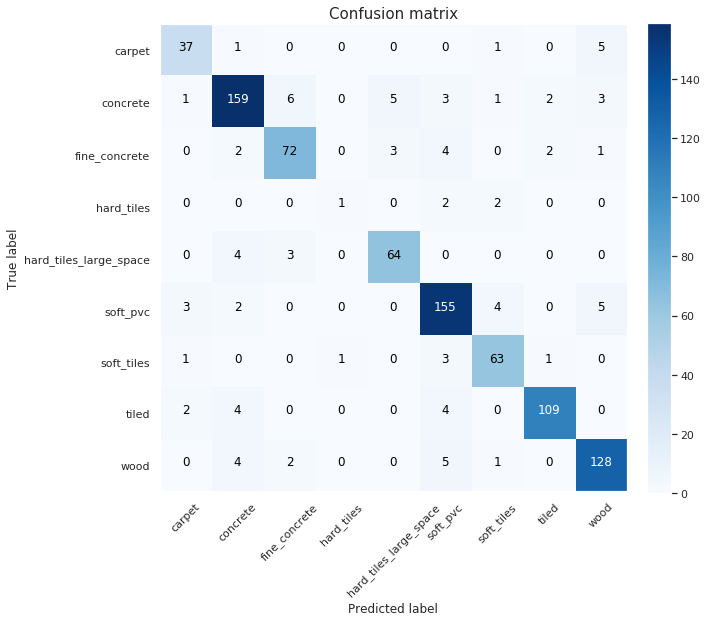

In [52]:
plot_confusion_matrix(y_va, pred_va, classes=le.classes_)

<br>

- permutation importance

> https://github.com/fkubota/LightningTalk/blob/master/003_permutation_importance/LT_permutation_importance.ipynb

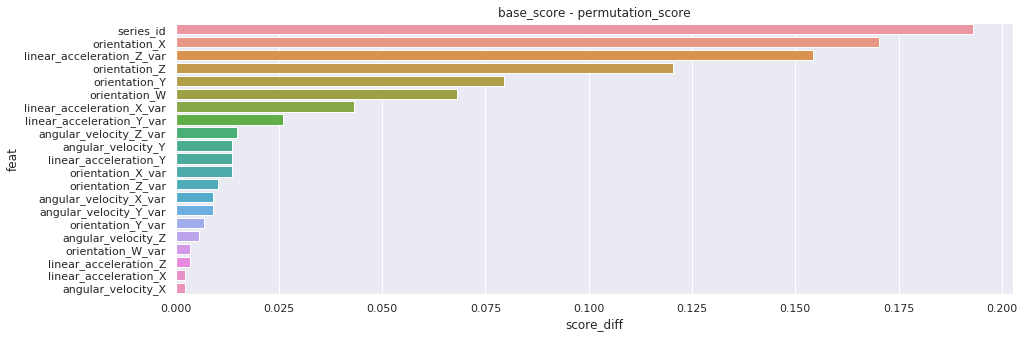

In [53]:
pi = permutation_importance(model, accuracy_score) # model と metric を渡す
pi.compute(X_va, y_va)
pi.show_permutation_importance(score_type='accuracy_score')  # loss or accuracy

model = RandomForestClassifier(random_state=42)

scores = cross_val_score(model, X_plus_var, y)
print('Cross-Validation scores: {}'.format(scores))
print('Average score: {}'.format(np.mean(scores)))

# Submission
- 作成したモデルでテストデータを評価する

In [54]:
pred_te = model.predict(X_plus_std_te)

In [55]:
submission = pd.DataFrame(df_X_te['series_id'].unique(), columns=['series_id'])
submission['surface'] = le.inverse_transform(pred_te)

In [56]:
submission

,series_id,surface
0,0,fine_concrete
1,2,fine_concrete
2,9,tiled
3,10,soft_pvc
4,13,carpet
...,...,...
1138,3800,concrete
1139,3804,tiled
1140,3807,tiled
1141,3808,tiled


<br>

submission data を渡す

In [57]:
accuracy = tell_me_score(submission)
print(f'accuracy score:{accuracy :.3f}')

accuracy score:0.858


In [58]:
# zcr 追加 0.748 → 0.756
# centroid 追加 0.761 → 0.773
# bandwidth 追加 0.767 → 0.770
# flatness 追加 0.716 → 0.781
# rolloff 追加 0.766　→ 0.757
# lpc 追加 0.701